In [1]:
# Read in CSV files

import pandas as pd
import itertools

target_genes = pd.read_csv('aggregated_results.csv')
gene_essentiality = pd.read_csv('CRISPRGeneEffect.csv')
model_id = pd.read_csv('Model.csv')

C:\Users\josep\AppData\Local\Temp\ipykernel_17148\2426754893.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# In CRISPRGeneEffect.csv, some cell lines don't have a classification so we drop them (since we need to tell whether a cell line has ecDNA or not)

def has_empty_list(row, columns):
    for col in columns:
        if row[col] == "[]":
            return True
    return False

target_genes = target_genes.dropna(subset=['Classification', 'All genes'])
target_genes = target_genes[~target_genes.apply(lambda x: has_empty_list(x, ['All genes']), axis=1)]
target_genes

,Unnamed: 0,Sample name,AA amplicon number,Feature ID,Classification,Location,Oncogenes,Complexity score,Captured interval length,Feature median copy number,...,Tissue of origin,Sample type,Feature BED file,CNV BED file,AA PNG file,AA PDF file,AA summary file,Run metadata JSON,Sample metadata JSON,All genes
0,0,5637_URINARY_TRACT,1.0,5637_URINARY_TRACT_amplicon1_ecDNA_1,ecDNA,['chr6:20350615-22839372'],"['E2F3', 'SOX4']",1.223167,2488757.0,29.757287,...,urinary tract,cell line,/Users/jluebeck/Desktop/research/CCLE/hg38/ccl...,/Users/jluebeck/Desktop/research/CCLE/hg38/ccl...,/Users/jluebeck/Desktop/research/CCLE/hg38/CCL...,/Users/jluebeck/Desktop/research/CCLE/hg38/CCL...,/Users/jluebeck/Desktop/research/CCLE/hg38/CCL...,/Users/jluebeck/Desktop/research/CCLE/hg38/ccl...,/Users/jluebeck/Desktop/research/CCLE/hg38/ccl...,"['CASC15', 'CDKAL1', 'E2F3', 'HDGFL1', 'NBAT1'..."
1,1,5637_URINARY_TRACT,1.0,5637_URINARY_TRACT_amplicon1_ecDNA_2,ecDNA,"['chr3:9099507-9519221', 'chr3:9521655-1018449...","['FANCD2', 'PPARG', 'RAF1', 'SRGAP3', 'VHL']",0.709581,4901014.0,13.175019,...,urinary tract,cell line,/Users/jluebeck/Desktop/research/CCLE/hg38/ccl...,/Users/jluebeck/Desktop/research/CCLE/hg38/ccl...,/Users/jluebeck/Desktop/research/CCLE/hg38/CCL...,/Users/jluebeck/Desktop/research/CCLE/hg38/CCL...,/Users/jluebeck/Desktop/research/CCLE/hg38/CCL...,/Users/jluebeck/Desktop/research/CCLE/hg38/ccl...,/Users/jluebeck/Desktop/research/CCLE/hg38/ccl...,"['ARPC4', 'ARPC4-TTLL3', 'ATG7', 'ATP2B2', 'AT..."
2,2,59M_OVARY,1.0,59M_OVARY_amplicon1_Complex non-cyclic_1,Complex non-cyclic,"['chr5:51400000-52863895', 'chr9:104220123-104...",[],0.935892,3998398.0,5.026093,...,ovary,cell line,/Users/jluebeck/Desktop/research/CCLE/hg38/ccl...,/Users/jluebeck/Desktop/research/CCLE/hg38/ccl...,/Users/jluebeck/Desktop/research/CCLE/hg38/CCL...,/Users/jluebeck/Desktop/research/CCLE/hg38/CCL...,/Users/jluebeck/Desktop/research/CCLE/hg38/CCL...,/Users/jluebeck/Desktop/research/CCLE/hg38/ccl...,/Users/jluebeck/Desktop/research/CCLE/hg38/ccl...,"['ABCA1', 'DNAJC25', 'DNAJC25-GNG10', 'ECPAS',..."
3,3,59M_OVARY,2.0,59M_OVARY_amplicon2_ecDNA_2,ecDNA,"['chr8:124484622-125582885', 'chr8:125588889-1...",['TRIB1'],0.366705,1463324.0,10.047201,...,ovary,cell line,/Users/jluebeck/Desktop/research/CCLE/hg38/ccl...,/Users/jluebeck/Desktop/research/CCLE/hg38/ccl...,/Users/jluebeck/Desktop/research/CCLE/hg38/CCL...,/Users/jluebeck/Desktop/research/CCLE/hg38/CCL...,/Users/jluebeck/Desktop/research/CCLE/hg38/CCL...,/Users/jluebeck/Desktop/research/CCLE/hg38/ccl...,/Users/jluebeck/Desktop/research/CCLE/hg38/ccl...,"['MTSS1', 'NDUFB9', 'NSMCE2', 'SQLE', 'TATDN1'..."
4,4,59M_OVARY,2.0,59M_OVARY_amplicon2_ecDNA_1,ecDNA,"['chr8:52712046-56014576', 'chr8:65533018-6557...",['TCEA1'],1.074874,3343884.0,15.129375,...,ovary,cell line,/Users/jluebeck/Desktop/research/CCLE/hg38/ccl...,/Users/jluebeck/Desktop/research/CCLE/hg38/ccl...,/Users/jluebeck/Desktop/research/CCLE/hg38/CCL...,/Users/jluebeck/Desktop/research/CCLE/hg38/CCL...,/Users/jluebeck/Desktop/research/CCLE/hg38/CCL...,/Users/jluebeck/Desktop/research/CCLE/hg38/ccl...,/Users/jluebeck/Desktop/research/CCLE/hg38/ccl...,"['ATP6V1H', 'LYN', 'LYPLA1', 'MRPL15', 'NPBWR1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,1154,VMCUB1_URINARY_TRACT,4.0,VMCUB1_URINARY_TRACT_amplicon4_Complex non-cyc...,Complex non-cyclic,"['chr11:61640343-61747022', 'chr11:61749300-61...",[],1.323104,223303.0,5.746610,...,urinary tract,cell line,/Users/jluebeck/Desktop/research/CCLE/hg38/ccl...,/Users/jluebeck/Desktop/research/CCLE/hg38/ccl...,/Users/jluebeck/Desktop/research/CCLE/hg38/CCL...,/Users/jluebeck/Desktop/research/CCLE/hg38/CCL...,/Users/jluebeck/Desktop/research/CCLE/hg38/CCL...,/Users/jluebeck/Desktop/research/CCLE/hg38/ccl...,/Users/jluebeck/Desktop/research/CCLE/hg38/ccl...,"['DAGLA', 'FADS1', 'FADS2', 'FEN1', 'MYRF', 'M..."
1156,1156,ZR751_BREAST,1.0,ZR751_BREAST_amplicon1_Complex non-cyclic_1,

In [3]:
# We get all the genes in the 'All genes' column and put them in a set (all unique)

import ast
genes = target_genes['All genes'].tolist()
genes = [ast.literal_eval(g) for g in genes]
genes = [item for sublist in genes for item in sublist]
genes = set(genes)
len(genes)

9032

In [4]:
# We replace the cell line names in CRISPRGeneEffect.csv with the corresponding CCLE names from Models.csv

for index, row in gene_essentiality.iterrows():
    id = row['Unnamed: 0']
    name = model_id.loc[model_id["ModelID"] == id, "CCLEName"].values[0]
    gene_essentiality.at[index, 'Unnamed: 0'] = name

# We rename columns to only include the gene names (no integers or parentheses, etc.)
def clean_column_names(df):
    df.columns = df.columns.str.replace(r'\(\d+\)', '', regex=True)  # Remove integers within parentheses
    df.columns = df.columns.str.replace(r'\d+', '', regex=True)      # Remove all other integers
    df.columns = df.columns.str.replace(r'\(\)', '', regex=True)     # Remove empty parentheses, if any
    df.columns = df.columns.str.strip()                              # Remove leading/trailing whitespaces
    return df

gene_essentiality = clean_column_names(gene_essentiality)

In [5]:
# We filter the cell lines in target_genes to only include the ones that are in gene_essentiality

filtered_cell_lines = []
for cell_line in list(target_genes['Sample name']):
    if cell_line in list(gene_essentiality['Unnamed:']):
        filtered_cell_lines.append(cell_line)
filtered_cell_lines    

['5637_URINARY_TRACT',
 '5637_URINARY_TRACT',
 '59M_OVARY',
 '59M_OVARY',
 '59M_OVARY',
 '59M_OVARY',
 '59M_OVARY',
 '8305C_THYROID',
 'A3KAW_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'A3KAW_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'ABC1_LUNG',
 'ABC1_LUNG',
 'ABC1_LUNG',
 'ABC1_LUNG',
 'ABC1_LUNG',
 'ABC1_LUNG',
 'AGS_STOMACH',
 'AU565_BREAST',
 'AU565_BREAST',
 'AU565_BREAST',
 'AU565_BREAST',
 'AU565_BREAST',
 'AU565_BREAST',
 'BFTC909_KIDNEY',
 'BFTC909_KIDNEY',
 'BFTC909_KIDNEY',
 'C2BBE1_LARGE_INTESTINE',
 'C2BBE1_LARGE_INTESTINE',
 'C2BBE1_LARGE_INTESTINE',
 'CAL120_BREAST',
 'CAL120_BREAST',
 'CAL120_BREAST',
 'CAL120_BREAST',
 'CAL27_UPPER_AERODIGESTIVE_TRACT',
 'CAL27_UPPER_AERODIGESTIVE_TRACT',
 'CALU6_LUNG',
 'CALU6_LUNG',
 'CAMA1_BREAST',
 'CAMA1_BREAST',
 'CAMA1_BREAST',
 'CAOV3_OVARY',
 'CAOV3_OVARY',
 'CAOV3_OVARY',
 'CHAGOK1_LUNG',
 'CHAGOK1_LUNG',
 'CHAGOK1_LUNG',
 'CHAGOK1_LUNG',
 'CHAGOK1_LUNG',
 'CHAGOK1_LUNG',
 'CHAGOK1_LUNG',
 'CHAGOK1_LUNG',
 'CHP212_AUTONOMIC_GANGLIA'

In [6]:
# We filter the genes in the gene_essentiality file to only include the ones that are in the target_genes file
filtered_genes = ['Unnamed:']
for gene in genes:
    if gene in gene_essentiality.columns:
        filtered_genes.append(gene)

gene_essentiality = gene_essentiality[list(filtered_genes)]
gene_essentiality = gene_essentiality[gene_essentiality["Unnamed:"].isin(filtered_cell_lines)]

In [28]:
# gene_essentiality now only contains the cell lines and genes that are in both files (target_genes and CRISPRGeneEffect)
gene_essentiality

,Unnamed:,SCGN,APMAP,RRAGB,SYBU,MDFI,SARNP,PDGFA,FBL,PCARE,...,COCH,OSTN,PRKCH,DSTN,YDJC,HNRNPAB,HNRNPAB,PRKCA,AGTRAP,PILRB
0,NIHOVCAR3_OVARY,-0.281239,-0.146281,-0.245795,0.003493,-0.072973,-0.327824,0.136487,-1.239287,0.113512,...,0.053182,0.012923,0.042961,-0.106607,0.009549,-0.453648,0.101231,-0.185704,0.302781,0.168423
2,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.126763,-0.107478,-0.242291,-0.202894,0.149917,0.106920,0.000709,-1.681280,-0.181241,...,0.052963,0.180487,0.081023,-0.050841,-0.102065,-0.078952,0.173745,0.087048,0.176669,0.052712
4,C2BBE1_LARGE_INTESTINE,0.040626,0.106509,-0.101057,0.008219,0.138636,-0.093870,-0.010902,-1.377604,0.057608,...,-0.069952,0.253576,-0.077865,-0.391924,0.061472,0.078135,-0.146618,-0.283232,-0.024169,-0.111738
6,HCC827_LUNG,-0.023990,0.101083,-0.025093,0.001143,0.223194,-0.055183,0.005290,-0.847131,0.059221,...,-0.108839,0.230878,-0.081736,-0.555686,0.097891,-0.443183,0.047329,-0.152211,0.165011,-0.146473
11,MCF7_BREAST,-0.068242,0.003744,0.194957,-0.139801,0.224233,-0.709706,-0.128226,-1.036092,-0.185076,...,-0.312845,0.271467,-0.083943,-0.141364,-0.054373,-0.000433,0.040931,-0.308953,0.227006,0.019509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,RL952_ENDOMETRIUM,-0.095850,0.004578,-0.744073,0.207107,0.250226,-0.427127,-0.108143,-1.327936,-0.028481,...,-0.126759,0.115790,-0.110489,-0.473918,-0.001107,-0.274705,-0.113984,-0.245492,0.112660,0.061156
638,DU145_PROSTATE,0.027578,0.035691,-0.226423,0.053017,0.076363,-0.263582,-0.065613,-1.140038,0.072877,...,-0.264668,0.337322,-0.016726,-0.057010,-0.026923,-0.762412,-0.032619,-0.143575,0.122010,0.141539
690,SKMEL2_SKIN,0.007240,-0.003480,-0.115825,0.002411,0.246343,-0.066977,-0.000432,-1.635636,0.111015,...,-0.271624,0.220770,-0.066478,-0.136774,0.291582,-0.321762,0.064950,-0.296020,0.140798,0.040963
718,8305C_THYROID,0.014513,0.256173,-0.176357,0.236633,0.209061,-0.431840,-0.240096,-1.796393,0.068704,...,-0.017260,0.169869,-0.168864,-0.153988,0.104129,-0.042852,0.119632,-0.125133,0.025728,-0.097191


In [12]:
# We create a dictionary where the key is the gene name and the value is a tuple containing two lists: one for the ecDNA cell lines and one for the non-ecDNA cell lines

ecDNA_vals = []
non_ecDNA_vals = []
gene_dict = {}

for col in gene_essentiality.columns:
    ecDNA_vals = []
    non_ecDNA_vals = []
    if col == "Unnamed:":
        continue
    for index in target_genes.index:
        if col in target_genes.loc[index]["All genes"]:
            if target_genes.loc[index]["Classification"] == "ecDNA":
                ecDNA_vals.append(gene_essentiality[gene_essentiality["Unnamed:"] == target_genes.loc[index]["Sample name"]][col])
            else:
                non_ecDNA_vals.append(gene_essentiality[gene_essentiality["Unnamed:"] == target_genes.loc[index]["Sample name"]][col])
    gene_dict[col] = (ecDNA_vals, non_ecDNA_vals)            

In [13]:
# We create a DataFrame from the dictionary
df = pd.DataFrame(gene_dict)

In [14]:
df

,SCGN,APMAP,RRAGB,SYBU,MDFI,SARNP,PDGFA,FBL,PCARE,JUN,...,GALP,COCH,OSTN,PRKCH,DSTN,YDJC,HNRNPAB,PRKCA,AGTRAP,PILRB
0,[],[],[],[[]],"[[0.3041787798967653], [0.1752574589376855]]",[],[],[[-1.042972583889523]],[],[[-0.9575894671961296]],...,[],[[]],[],[[-0.216460657675454]],[[-0.2399340388242574]],[],[],[],[],[]
1,[[0.017962699495228]],[[]],[[-0.0283665856986013]],[],"[[0.1395554410121172], [0.2210285287990405], [...",[[-0.5976477198759991]],[[-0.2399113289334158]],"[[], [-1.3028856490330851], [], [-1.4900573397...",[[-0.420219760913402]],[],...,[[0.0811619475345834]],"[[-0.2646682808093423], [-0.2288824895193493],...","[[0.1258493312237801], [], []]",[],[[]],"[[0.0971804844951759], [-0.0619556987225338], ...",[[]],[[-0.445160644982011]],[[-0.1772163134087429]],[[-0.1537169550149144]]


In [15]:
# We filter out the NaN values and flatten the lists to make them look nice.
import numpy as np

def flatten_and_filter(arr):
    if isinstance(arr, np.ndarray):
        return [value for value in arr if not np.isnan(value)]
    else:
        return [arr]

for key, value in df.items():
    combined_list = []
    for series in df[key][0]:
        if not series.empty:
            combined_list.extend(series.values)
    combined_list = [item for sublist in map(flatten_and_filter, combined_list) for item in sublist]
    combined_list =  [x for x in combined_list if not np.isnan(x)]
    df[key][0] = combined_list
    combined_list = []
    for series in df[key][1]:
        if not series.empty:
            combined_list.extend(series.values)
    combined_list = [item for sublist in map(flatten_and_filter, combined_list) for item in sublist]
    combined_list =  [x for x in combined_list if not np.isnan(x)]
    df[key][1] = combined_list

In [16]:
df2 = df.applymap(lambda x: np.nan if x == [] else x)

C:\Users\josep\AppData\Local\Temp\ipykernel_17148\4056168146.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df.applymap(lambda x: np.nan if x == [] else x)


In [17]:
df_cleaned = df2.dropna(axis=1)
df = df_cleaned

In [18]:
df2 = df
df2

,MDFI,FBL,CREBZF,TPPP,RIDA,MYCBP,LYZ,ASNS,CFTR,PPARG,...,NFKBIA,GSDMB,RHOD,NGF,SINHCAF,WAC,ALB,EAPP,PLAT,RGN
0,"[0.3041787798967653, 0.1752574589376855]",[-1.042972583889523],[-0.2346821954434589],"[-0.7592414254813573, 0.0136106012965065, 0.12...",[-0.032729017941533],"[-0.1962204571957108, -0.0106103052325006]",[-0.224228055256449],[-0.5590237010837559],"[0.0856209440432326, -0.0655358928148532]",[-0.741373085738194],...,"[-0.6252306727313923, 0.1517316228728096]","[-0.3270806014146133, -1.9019031923298653]","[-0.1096476718289736, -0.0211187090704489]","[-0.2803852097718528, 0.1234621804694471]",[-0.4237313060339102],[-1.0526140564430015],"[0.1048884871490809, 0.0550207815698997]","[-0.6121031646512752, -0.6175112573847241]","[0.1400757617790999, 0.1846299636093831]",[-0.0525289700075418]
1,"[0.1395554410121172, 0.2210285287990405, 0.171...","[-1.3028856490330851, -1.490057339709168, -1.2...","[-0.0039510113496209, 0.1127726137044503]","[-0.1878534628084688, 0.0174515340812878, 0.08...",[-0.1331527317848843],[-0.1438934704891402],"[0.0588043080737235, 0.0079617654401657, -0.02...",[-0.1441364695892068],"[-0.0268903597885336, -0.626512164722995]",[0.0330327495885418],...,"[-0.1248771768453196, -0.2258994082697713, -0....","[-0.885200361475016, -0.1265536625894899, -0.5...","[-0.1716828966651562, -0.1913895765618194, 0.1...",[0.0353663986648608],"[-1.2168402615465896, -1.0164636915060534]","[-0.2796682934682707, -0.5221352214583607]","[0.0343351648324313, -0.047351157205284, 0.058...","[-0.6006950695914117, -2.6396740722230256]",[0.1646334064098994],[-0.0520972493851065]


In [19]:
df = df2.iloc[:, :100]

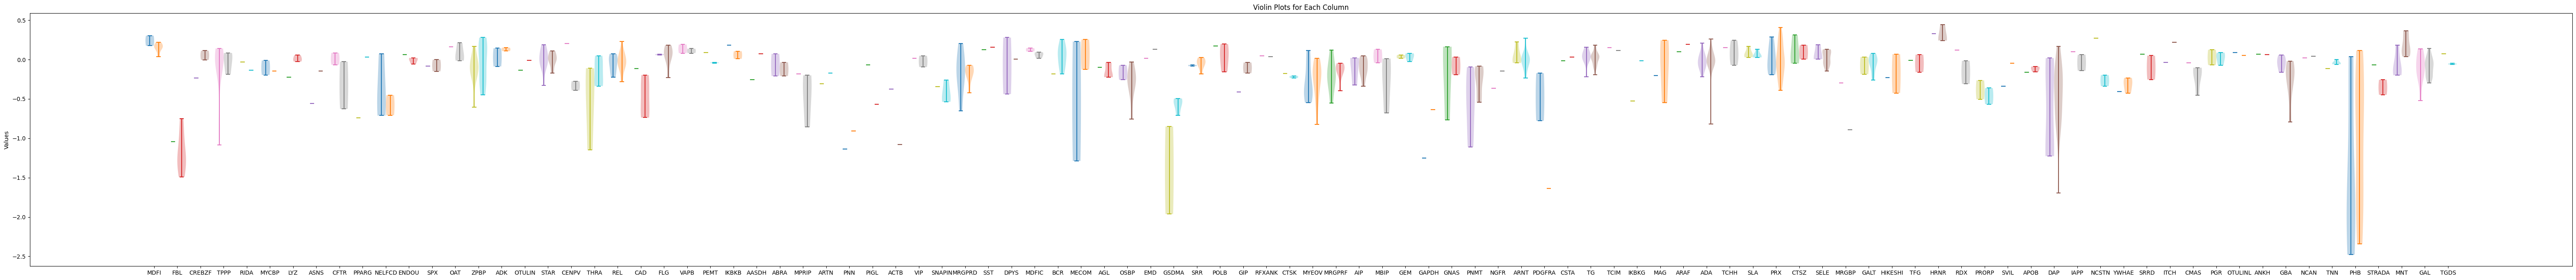

In [20]:
import matplotlib.pyplot as plt

# Set the width of each violin
violin_width = 0.3

# Set the space between each group of violins
space_between_groups = 0.5

# Calculate the number of columns and the total width
num_cols = len(df.columns)
total_width = num_cols * (violin_width + space_between_groups)

# Create the figure
fig, ax = plt.subplots(figsize=(total_width, 8))

# Iterate over each column
for i, col in enumerate(df.columns):
    # Calculate the position of the violins
    x_position = i * (violin_width + space_between_groups)
    
    # Plot the violins for the first row
    ax.violinplot(df[col][0], positions=[x_position], widths=violin_width)
    
    # Plot the violins for the second row
    ax.violinplot(df[col][1], positions=[x_position + violin_width], widths=violin_width)

# Set the x-axis tick labels
tick_positions = [i * (violin_width + space_between_groups) + violin_width / 2 for i in range(num_cols)]
ax.set_xticks(tick_positions)
ax.set_xticklabels(df.columns)

# Set y-axis label
ax.set_ylabel("Values")

# Set title
ax.set_title("Violin Plots for Each Column")

# Show the plot
plt.show()


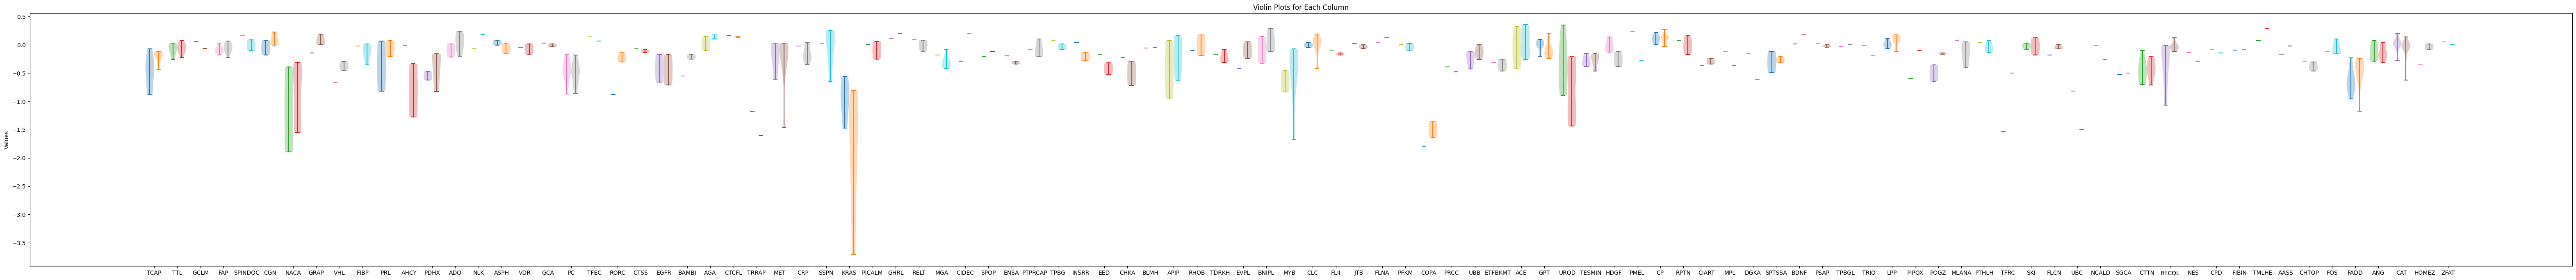

In [21]:
df = df2.iloc[:, 100:200]
import matplotlib.pyplot as plt

# Set the width of each violin
violin_width = 0.3

# Set the space between each group of violins
space_between_groups = 0.5

# Calculate the number of columns and the total width
num_cols = len(df.columns)
total_width = num_cols * (violin_width + space_between_groups)

# Create the figure
fig, ax = plt.subplots(figsize=(total_width, 8))

# Iterate over each column
for i, col in enumerate(df.columns):
    # Calculate the position of the violins
    x_position = i * (violin_width + space_between_groups)
    
    # Plot the violins for the first row
    ax.violinplot(df[col][0], positions=[x_position], widths=violin_width)
    
    # Plot the violins for the second row
    ax.violinplot(df[col][1], positions=[x_position + violin_width], widths=violin_width)

# Set the x-axis tick labels
tick_positions = [i * (violin_width + space_between_groups) + violin_width / 2 for i in range(num_cols)]
ax.set_xticks(tick_positions)
ax.set_xticklabels(df.columns)

# Set y-axis label
ax.set_ylabel("Values")

# Set title
ax.set_title("Violin Plots for Each Column")

# Show the plot
plt.show()
